# Figure 17b and 18: Re-invasion probability estimates and expected time until re-invasion vs probability of vertical transmission $v$

## Abby Barlow, University of Bath
## Ben Adams, University of Bath

Importing required libraries

In [1]:
import numpy as np
import itertools
import pylab as plt
import matplotlib

Importing required scripts

In [2]:
import importlib
import Rate_transitions
import Finding_full_Q
import Tridiagonalisation
import Finding_sub_Q
import Finding_dictionary_keys
import Prob_absorb_to_each
import Time_absorb_wild_states
import Hughes_model

get_transition = Rate_transitions.get_transition_Hughes
getQ = Finding_full_Q.getQ_Hughes
tridiagonal = Tridiagonalisation.tridiagonal
getQk = Finding_sub_Q.getQk_Hughes
find_keys = Finding_dictionary_keys.find_keys
prob_reach_absorb = Prob_absorb_to_each.prob_reach_absorb_Hughes
absorb_time_wild = Time_absorb_wild_states.absorb_time_wild_Hughes
F = Hughes_model.F_hughes

# scripts autosave, so no need to re-run code chunk after making changes
%load_ext autoreload
%autoreload 2

Constructing a dictionary for the full state space

In [3]:
# construct a dictionary that associated an integer index with each possible states, states are stored as an np.array - easier to apply mathematical operations than tuple 
max_pop = 30   # maximum household size
state_dict = {index: np.array((i, j)) for index, (i, j) in enumerate([(i, j) for i in range(max_pop + 1) for j in range(max_pop + 1) if i + j <= max_pop])}
# construct a matrix Q for the transition rate q_ij betweeen states i and j
n_states = len(state_dict)   # total number of states

Dictionaries for separate communicating classes

In [4]:
### S1 corresponds to the wild-type-only states, S2 to the Wolbachia-only and mixed states
state_dict_S1 = {index: np.array((i, 0)) for index, i in enumerate([i for i in range(1,max_pop + 1)])}
state_dict_S2 = {index: np.array((i,j)) for index, (i,j) in enumerate([(i, j) for i in range(max_pop + 1) for j in range(1,max_pop + 1) if i + j <= max_pop])}

Parameter values

In [5]:
K = 30        # reproductive carrying capacity
d1 = 12/100   # wild-type death rate
d2 = 12/100   # Wolbachia death rate
phi = 9/10    # Wolbachia fitness

v = 9/10      # probability of vertical transmission
u = 10/10     # ratio of unviable offspring produced by an infected male and uninfected female

k = 0.3           # Mosquito competition parameter
h = 0.19*100**k   # Mosquito competition parameter

b1 = round(d1/F(10,h,k),2) # wild-type per capita birth rate
b2 = b1*phi                # Wolbachia per capita birth rate

Calculating the reversion probability over a range of $v$ values

In [6]:
n_transient = len(state_dict_S2)  # transient states here are mixed and wolbachia-only
uvec2 = np.load('uvec2.npy')  # loading in Wolbachia-only QSD, see 'Wolbachia_only_QSD.ipynb'
vvec = np.linspace(0,1,11)    # array of v values
vrange = len(vvec)            # number of v values
revert_prob_vec = np.zeros(vrange)   # initial array for the probabilities of re-invasion

for i in range(vrange):        # looping over the v values
    params_dict = {'b1': b1,   # parameter dictionary, need to define here as v changes
              'b2': b2,
              'K': K,
              'd1': d1,
              'd2': d2,
              'v': vvec[i],
              'phi': phi,
              'u': u,
              'h': h,
              'k': k
              }
    # initialise array to store probabilities of reaching the the wild-type-only state space from the other states
    prob_reach_wild = np.zeros(n_transient)  
    for j in range(max_pop):               # looping over wild-type-only states
        absorb_state = np.array([j+1,0])   # current wild-type-only state
        # adding the probabilities of reaching that wild-type state from all the transient states
        prob_reach_wild[:] += np.transpose(prob_reach_absorb(state_dict,state_dict_S2,absorb_state,params_dict)[0])[0]
    # we need to condition on the Wolbachia-only QSD for the (approximate) probability of re-invasion
    # remember we only want the probabilities corresponding to initial states that are Wolbachia-only
    revert_prob_vec[i] = prob_reach_wild[:max_pop]@np.transpose(uvec2)   # record the probability for current v
np.append(revert_prob_vec, 0)  # probability of re-invasion is 0 when v=1

array([9.21450075e-01, 9.13222373e-01, 9.02828249e-01, 8.89329327e-01,
       8.71194963e-01, 8.45786602e-01, 8.08240703e-01, 7.48827443e-01,
       6.46035132e-01, 4.46341430e-01, 3.07815930e-15, 0.00000000e+00])

Plotting the figure

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


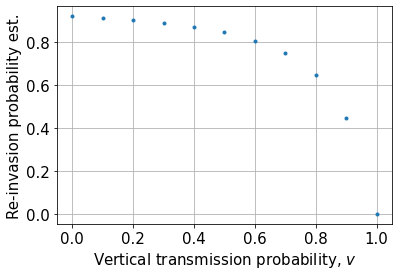

In [7]:
matplotlib.rcParams.update({'font.size': 15})  # font size

plt.plot(vvec,revert_prob_vec,'.')                      # plotting the probabilities   
plt.xlabel('Vertical transmission probability, $v$')    # x label
plt.ylabel('Re-invasion probability est.')              # y label
plt.grid()                                        # adds grid
plt.savefig('re-invasion_prob_v_dye.pdf', bbox_inches='tight')    # save figure

Finding the expected times to re-invasion for the range of $v$ values

In [8]:
uvec2 = np.load('uvec2.npy')              # loading in the Wolbachia-only QSD
vvec = np.linspace(0,1,11)                # v range
vrange = len(vvec)                        # number of v values
revert_time_vec = np.zeros(vrange)        # initialise array to hold expected times until re-invasion
n_transient = len(state_dict_S2)          # number of transient states (mixed and Wolbachia-only)

for i in range(vrange):         # looping over the v values
    params_dict = {'b1': b1,    # parameter dictionary, need to define here as v changes
              'b2': b2,
              'K': K,
              'd1': d1,
              'd2': d2,
              'v': vvec[i],
              'phi': phi,
              'u': u,
              'h': h,
              'k': k
              }
    # calculating the expected times until re-invasion for each transient state and recording it 
    # for each v value
    # we again condition on the Wolbachia-only QSD
    # remember we only want the times corresponding to initial states that are Wolbachia-only
    revert_time_vec[i] = absorb_time_wild(max_pop,np.ones(n_transient),params_dict)[:max_pop]@np.transpose(uvec2)

Plotting the figure

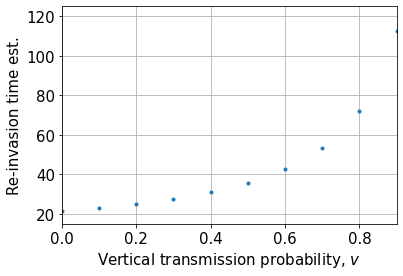

In [9]:
matplotlib.rcParams.update({'font.size': 15})  # font size
plt.plot(vvec,revert_time_vec,'.')             # plotting the expected times until re-invasion
plt.xlabel('Vertical transmission probability, $v$')   # x label
plt.ylabel('Re-invasion time est.')                    # y label
plt.xlim(0,0.9)    # x limit, expected time for re-invasion when v=1 is infinite
plt.ylim(15,125)   # y limit
plt.grid()         # adds grid
plt.savefig('re-invasion_time_v_dye.pdf', bbox_inches='tight')   # saves figure